In [2]:
import os
current_path = os.getcwd()
print(current_path)
os.chdir("..")
current_path = os.getcwd()
print(current_path)

/home/xzhang/Documents/我的模型/experiments
/home/xzhang/Documents/我的模型


In [3]:
# 第三个实验测试
# 选择了合适的学习率, 打算跑5000次然后记录图片并且查看相应的降噪成果，每次不同的用random seed，也就是有一个loop的
# 模型相关
import torch
from models.DIP_2D import DIP_2D
import pytorch_lightning as pl
import numpy as np
# 画图相关
import matplotlib.pyplot as plt
# 文件读写相关
import csv
from config.config import *
import pandas as pd
import csv
# 自定义函数
from utils.pre_utils import *
from functools import partial

import datetime

/home/xzhang/miniconda3/envs/dip/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/xzhang/miniconda3/envs/dip/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [4]:
path_input = "data/noisy_images/uniform_noise.npy"
path_ground_truth = "data/ground_truth/ground_truth.npy"
path_target = "data/corrupted_images/BSREM_it30.npy"

staaaaaaaaaaand


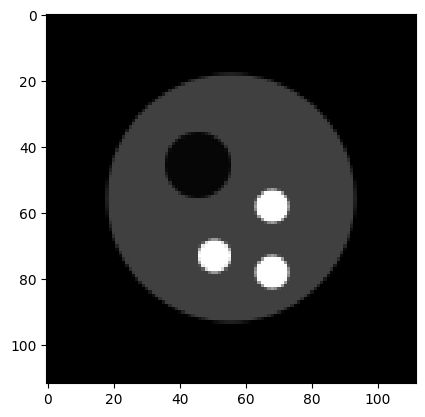

In [7]:
image_net_input = np.load(path_input)

# image_net_input_scale,param1_scale_im_net,param2_scale_im_net = rescale_imag(image_net_input,"standardization") 
# image_net_input_torch = torch.Tensor(image_net_input_scale)

image_net_input_torch = torch.Tensor(image_net_input)
image_net_input_torch = image_net_input_torch.view(1,1,PETImage_shape[0],PETImage_shape[1],PETImage_shape[2])
image_net_input_torch = image_net_input_torch[:,:,:,:,0]

ground_truth = np.load(path_ground_truth)

image_corrupt = np.load(path_target)
image_corrupt_input_scaled,param1_scale_im_corrupt,param2_scale_im_corrupt = rescale_imag(image_corrupt,"standardization") # 标准化图片, 减去平均值，除以标准差，参数1是mean，参数2是std
image_corrupt_torch = torch.Tensor(image_corrupt_input_scaled)
image_corrupt_torch = image_corrupt_torch.view(1,1,PETImage_shape[0],PETImage_shape[1],PETImage_shape[2])
image_corrupt_torch = image_corrupt_torch[:,:,:,:,0]

plt.imshow(ground_truth, cmap='gray')
plt.show()  

In [ ]:

# 到100遍
psnr_dict = dict()
for i in range(100):
    # 加载数据
    train_dataset = torch.utils.data.TensorDataset(image_net_input_torch,image_corrupt_torch)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1) 

    # 加载模型
    model = DIP_2D(param1_scale_im_corrupt, param2_scale_im_corrupt, config,'data/Algo/',
                "nested",all_images_DIP="False",global_it=-100, suffix=i,last_iter=-1,ground_truth=ground_truth)
    #model.init_weights()
    model_class = DIP_2D

    #定义tensorboard
    checkpoint_simple_path = os.getcwd() + '/test3_logs'
    # experiment = 24
    name=str(datetime.datetime.now())

    logger = pl.loggers.TensorBoardLogger(save_dir=checkpoint_simple_path,name=name)#version=format(experiment), name=name)
    trainer = pl.Trainer(max_epochs=config["sub_iter_DIP"],log_every_n_steps=1,logger=logger)#, callbacks=[checkpoint_callback, tuning_callback, early_stopping_callback], logger=logger,gpus=gpus, accelerator=accelerator, profiler="simple")

    # 训练模型
    trainer.fit(model, train_dataloader)
    out = model(image_net_input_torch)
    psnr_dict[f"{i}"] = model.psnr_list 
    
    image_out = out.view(PETImage_shape[0],PETImage_shape[1],PETImage_shape[2]).detach().numpy()
    image_concat = np.concatenate((image_corrupt, destand_numpy_imag(image_out,param1_scale_im_corrupt,param2_scale_im_corrupt)), axis=1)
    image_reversed = np.max(image_concat)-image_concat
    


In [5]:
# 测试用于保存的script,我想着每次运行完，把psnr的数据保存起来
import csv 

def write_csv(my_dict, file_name):
    nb_cols = len(list(my_dict.keys()))
    nb_rows = len(my_dict[f"{1}"])
    with open(file_name, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        # 写入表头
        header = ['iters'] + list(range(nb_cols))
        writer.writerow(header)
        
        # 写入数据
        for i in range(nb_rows):
            row = [i] + [my_dict[f"{j}"][i] for j in range(nb_cols)]
            writer.writerow(row)
            
write_csv(psnr_dict, file_name="my_file.csv")

NameError: name 'psnr_dict' is not defined

In [6]:
df = pd.read_csv('my_file.csv')
df.head()

,iters,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
3,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
4,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4


In [7]:
max_values = df.max()
max_indexes = df.idxmax()